# Chatbot Test Notebook

Analysis of a chatbot's performance using various metrics.

In [1]:
import textwrap
import json
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os

In [2]:

TEST_RESULTS_FP_LIST = [
    "test_results_df_semantic_gpt-3.5-turbo.pkl",
    "test_results_df_semantic_gpt-4o-mini.pkl",
    "test_results_df_semantic_gpt-4o.pkl",
]

TEST_RESULTS_DIR ="../results/"

In [3]:
all_results_df = pd.DataFrame()

for test_results_fp in TEST_RESULTS_FP_LIST:
    print(f"Loading {test_results_fp}...")
    # load test results
    with open(os.path.join(TEST_RESULTS_DIR,test_results_fp), "rb") as f:
        test_results_df = pickle.load(f)
    # add to all results
    all_results_df = pd.concat([all_results_df, test_results_df], ignore_index=True)

all_results_df.shape

Loading test_results_df_semantic_gpt-3.5-turbo.pkl...
Loading test_results_df_semantic_gpt-4o-mini.pkl...
Loading test_results_df_semantic_gpt-4o.pkl...


(168, 11)

In [4]:
all_results_df.columns

Index(['question', 'situation', 'query_time', 'response_eval_time',
       'llm_response', 'correctness_score', 'feedback', 'target', 'vector_db',
       'vector_db_path', 'llm_model'],
      dtype='object')

In [5]:
rag_llm_list = all_results_df["llm_model"].unique()
rag_llm_list

array(['gpt-3.5-turbo', 'gpt-4o-mini', 'gpt-4o'], dtype=object)

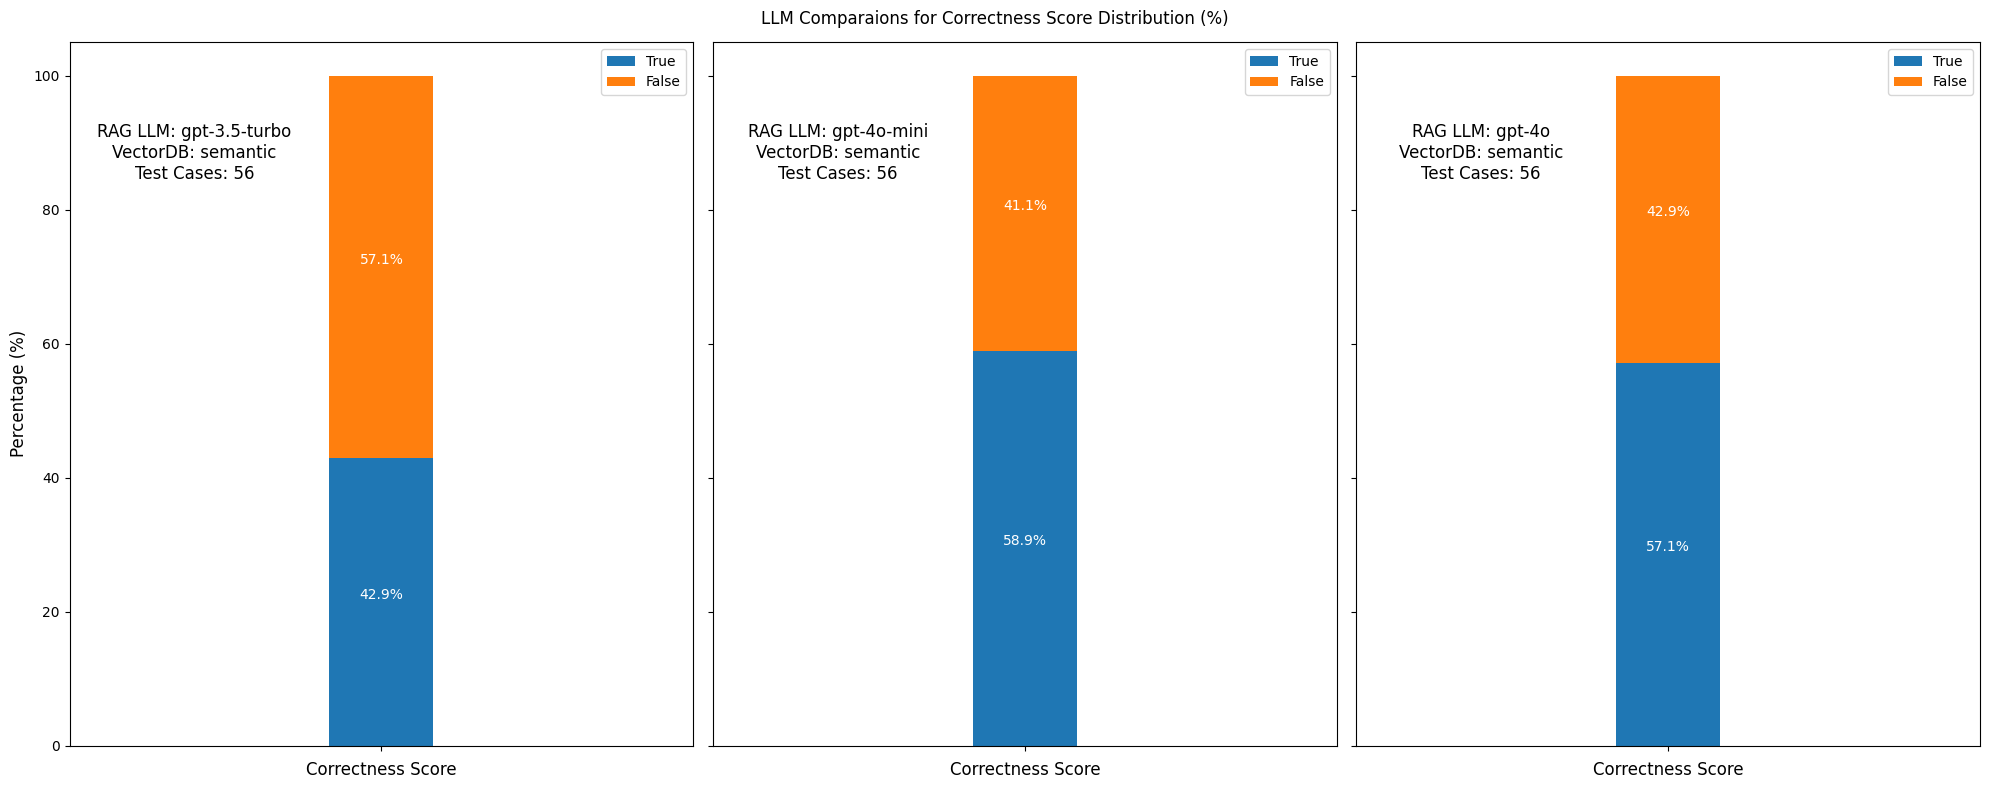

In [9]:

fig, ax = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

for i, llm_model in enumerate(rag_llm_list):

    # Filter the DataFrame for the current LLM model
    test_results_df = all_results_df[all_results_df['llm_model'] == llm_model]

    # Calculate value counts and normalize to percentages
    value_counts = test_results_df['correctness_score'].value_counts(normalize=True).mul(100)

    # Create a stacked bar plot
    df = pd.DataFrame(value_counts).T
    df.columns = value_counts.index.astype(str).to_list()
    df.rename(index={"proportion": 'correctness_score'}, inplace=True)
    df = df[["True", "False"]]
    value_counts = df.iloc[0].values
    df.plot.bar(stacked=True, ax=ax[i], width=0.1)
    
    ax[i].set_xticklabels([], rotation=0)
    ax[i].set_xlabel('Correctness Score', fontsize=12)
    ax[i].set_ylabel('Percentage (%)', fontsize=12)


    # label the bars with percentage values
    value_patches = zip(value_counts, ax[i].patches)
    for value, patch in value_patches:
        height = patch.get_height()
        ax[i].annotate(f'{value:.1f}%', 
                    xy=(patch.get_x() + patch.get_width() / 2, patch.get_y() + value / 2), 
                    ha='center', va='bottom', fontsize=10, color="white")
        
    # annotate chart with number of test cases
    total_test_cases = len(test_results_df)
    ax[i].annotate(f'RAG LLM: {test_results_df.llm_model.values[0]}\nVectorDB: {test_results_df.vector_db.values[0]}\nTest Cases: {total_test_cases}', 
                xy=(0.20, 0.8), 
                ha='center', va='bottom', fontsize=12, color="black", xycoords='axes fraction')


# Create stacked bar plot
plt.suptitle('LLM Comparaions for Correctness Score Distribution (%)')
plt.tight_layout()
plt.show()

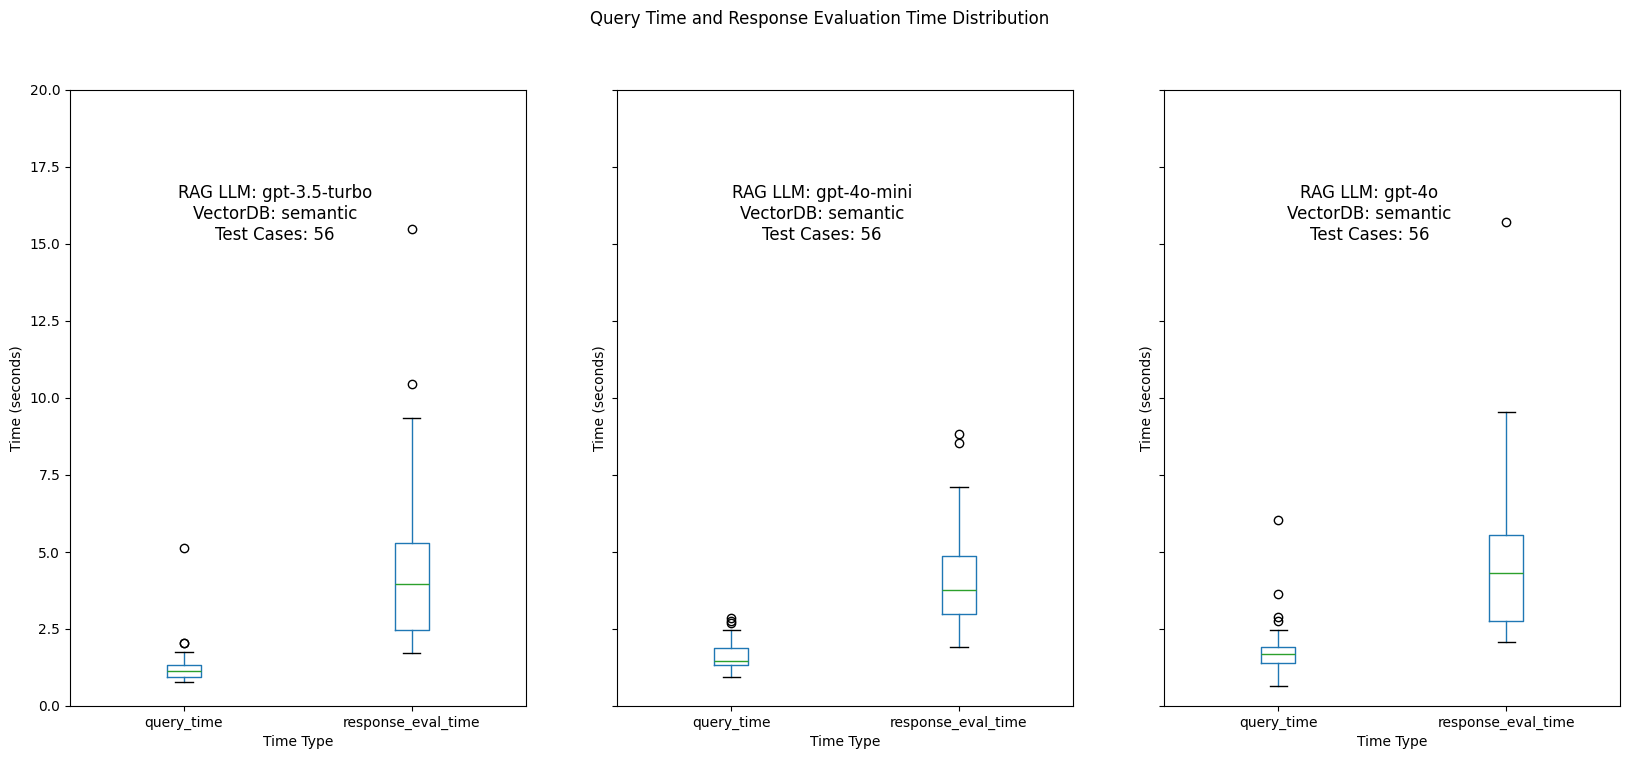

In [7]:
# boxplot for query_time and response_eval_time
fig, ax = plt.subplots(1, 3, figsize=(20, 8), sharey=True)  # Set the figure size
# Set the figure size

for i, llm_model in enumerate(rag_llm_list):
    # Filter the DataFrame for the current LLM model
    test_results_df = all_results_df[all_results_df['llm_model'] == llm_model]

    # Create boxplot
    test_results_df[["query_time", "response_eval_time"]].boxplot(ax=ax[i], grid=False)
    ax[i].set_ylabel('Time (seconds)')
    ax[i].set_xlabel('Time Type') 
    ax[i].set_ylim(0, 20)

    ax[i].annotate(f'RAG LLM: {llm_model}\nVectorDB: {test_results_df.vector_db.values[0]}\nTest Cases: {total_test_cases}', 
                xy=(0.45, 0.75), 
                ha='center', va='bottom', fontsize=12, color="black", xycoords='axes fraction')


plt.suptitle('Query Time and Response Evaluation Time Distribution')
plt.tight_layout
plt.show()

In [8]:
all_results_df[["llm_model", "query_time", "response_eval_time"]].groupby("llm_model").describe().T

llm_model                 gpt-3.5-turbo     gpt-4o  gpt-4o-mini
query_time         count      56.000000  56.000000    56.000000
                   mean        2.840736   1.767687     1.595674
                   std        12.063996   0.772726     0.435434
                   min         0.764809   0.629843     0.931218
                   25%         0.918603   1.396115     1.322629
                   50%         1.118230   1.670817     1.460867
                   75%         1.331514   1.916091     1.861780
                   max        91.395954   6.039591     2.837687
response_eval_time count      56.000000  56.000000    56.000000
                   mean        4.253607   4.441526     4.372046
                   std         2.433714   2.209886     2.738840
                   min         1.703280   2.048924     1.914617
                   25%         2.463286   2.750038     2.987473
                   50%         3.959911   4.318125     3.743223
                   75%         5.277367   5.532726     4.871247
                   max        15.465221  15.689516    21.097931